# Windower Repo Example 03: Performance Analysis and Comparison

This notebook evaluates the performance of both the original Kitsune and the proposed Windower feature extraction method. We use AUC scores, ROC curves, per-packet mitigation metrics, as well as overall per-window classification metrics for Windower's case.

This notebook assumes that the per-packet classification results and other auxiliary data produced by `00_dataset.ipynb`, `01_kitsune.ipynb` and `02_windower.ipynb` are already located under the `examples/work` folder. If you want to run the notebook and do not have the necessary files available, please run the mentioned notebooks in the specified numerical order.

## Preparation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.metrics

In [2]:
# We expect a current directory to be /examples in order for these variables to work
SRC_DIR  = '../src'
WORK_DIR = 'work'

In [3]:
# Extract packet timestamps from packets for plotting purposes
!tshark -r $WORK_DIR/ctu13_sc4_train.pcap -T fields -e 'frame.time_epoch' > $WORK_DIR/ctu13_sc4_train.tstamp
!tshark -r $WORK_DIR/ctu13_sc4_test.pcap -T fields -e 'frame.time_epoch' > $WORK_DIR/ctu13_sc4_test.tstamp

In [4]:
# Extract per-packet RMSE values (2nd column) from the mitig simulation packet file
!cut -d ',' -f 2 $WORK_DIR/predictions_windower.pkts > $WORK_DIR/predictions_windower_pkts.rmse

# Extract per-window RMSE values (2nd column) from the mitig simulation windows file
!cut -d ',' -f 2 $WORK_DIR/predictions_windower.wnds > $WORK_DIR/predictions_windower_winds.rmse

# Extract per-window true labels (3rd column) from the mitig simulation windows file
!cut -d ',' -f 3 $WORK_DIR/predictions_windower.wnds > $WORK_DIR/predictions_windower_winds.decs

In [5]:
# Load packet timestamps and labels
pkt_timestamps = np.genfromtxt(os.path.join(WORK_DIR, 'ctu13_sc4_test.tstamp'), delimiter='\n')
pkt_labels     = np.genfromtxt(os.path.join(WORK_DIR, 'ctu13_sc4_test_pktlabels.txt'), delimiter='\n')
winds_labels_windower = np.genfromtxt(os.path.join(WORK_DIR, 'predictions_windower_winds.decs'), delimiter='\n')


In [6]:
# Load predictions from Kitsune
pkt_rmse_kitsune = np.genfromtxt(os.path.join(WORK_DIR, 'predictions_kitsune_pkts.rmse'), delimiter='\n')

In [7]:
# Load predictions from Windower
pkt_rmse_windower   = np.genfromtxt(os.path.join(WORK_DIR, 'predictions_windower_pkts.rmse'), delimiter='\n')
winds_rmse_windower = np.genfromtxt(os.path.join(WORK_DIR, 'predictions_windower_winds.rmse'), delimiter='\n')

## Statistics Plotting and Auxilliary Functions

In [8]:
def plot_pkt_rmses(rmses: np.ndarray, labels: np.ndarray | None = None, tstamps: np.ndarray | None = None, *, 
    skip: int = 0, end: int | None = None, linthresh : float | None = None, scale: list = [2, 3],
    alpha: float = [0.5, 0.75]) -> None:
    """Plots per-packet RMSE scores.
    
    Parameters:
        rmses -- 1D NumPy array of per-packet RMSE values
        labels -- 1D NumPy array of 0/1 true packet labels
        tstamps -- 1D NumPy array of packet timestamps
        skip -- how many seconds from the start of the capture to ignore
        end -- how many second from the end to end plotting sooner
        linthresh -- the range (-x, x), within which the plot is linear (it avoids having the plot go to infinity around zero)
        scale -- the scale of the points
        alpha -- the scale of the points"""

    plt.figure(figsize=(10,3.5), dpi=400)

    
    test_rmses   = rmses[skip:end]
    test_labels  = labels[skip:end] if labels is not None else np.zeros_like(test_rmses)
    test_tstamps = None
    xlabel       = None

    if tstamps is not None:
        tstamps = tstamps - tstamps[skip]
        test_tstamps = tstamps[skip:end]
        xlabel = "time [seconds]"
    else:
        test_tstamps = np.arange(test_rmses.shape[0])
        xlabel = "N [packets]"

    # Plot benign packets
    test_tstamps_benign = test_tstamps[test_labels == 0]
    test_rmses_benign   = test_rmses[test_labels == 0]

    plt.scatter(test_tstamps_benign, test_rmses_benign, s=scale[0], c='darkgreen', label='_',
        rasterized=True, alpha=alpha[0], edgecolors='none')
    plt.scatter([], [], s=0.05, c='darkgreen', label='Benign packets')

    # Plot malicious packets
    test_tstamps_malicious = test_tstamps[test_labels == 1]
    test_rmses_malicious   = test_rmses[test_labels == 1]
    
    plt.scatter(test_tstamps_malicious, test_rmses_malicious, s=scale[1], c='darkred', label='_',
    rasterized=True, alpha=alpha[1], edgecolors='none')
    plt.scatter([], [], s=0.05, c='darkred', label='Attack packets')

    # Finalize the plot
    min_sample = np.amin(test_rmses, where=(test_rmses > 0), initial=1.0) if linthresh is None else linthresh

    plt.yscale("symlog", linthresh=min_sample, linscale=1.0)
    plt.xlabel(xlabel)
    plt.ylabel("RMSE (log scaled)")
    plt.legend(markerscale=25)
    plt.show()


In [9]:
def plot_roc(roc_elements: list[tuple[np.ndarray, np.ndarray, str, str]]) -> None:
    """Plots a ROC curve.
    
    Parameters:
        roc_elements - list of tuples defining packet mitigation results. A single tuple element is composed of: 
            rmses -- 1D NumPy array of per-packet RMSE values
            labels -- 1D NumPy array of 0/1 true packet labels
            name -- the name to plot
            color -- Matplotlib Pyplot's color to use"""
    
    # Iterate through all elements to plot
    for rmses, labels, name, color in roc_elements:
        fprs, tprs, _ = sklearn.metrics.roc_curve(labels, rmses)
        auc = sklearn.metrics.auc(fprs, tprs)

        plt.plot(fprs, tprs, color, label=f'{name} (AUC={auc:.2f})')

    plt.plot([0, 1], [0, 1], "darkgray", linestyle='dashed', label="Chance level (AUC=0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.show()

## Kitsune Evaluation

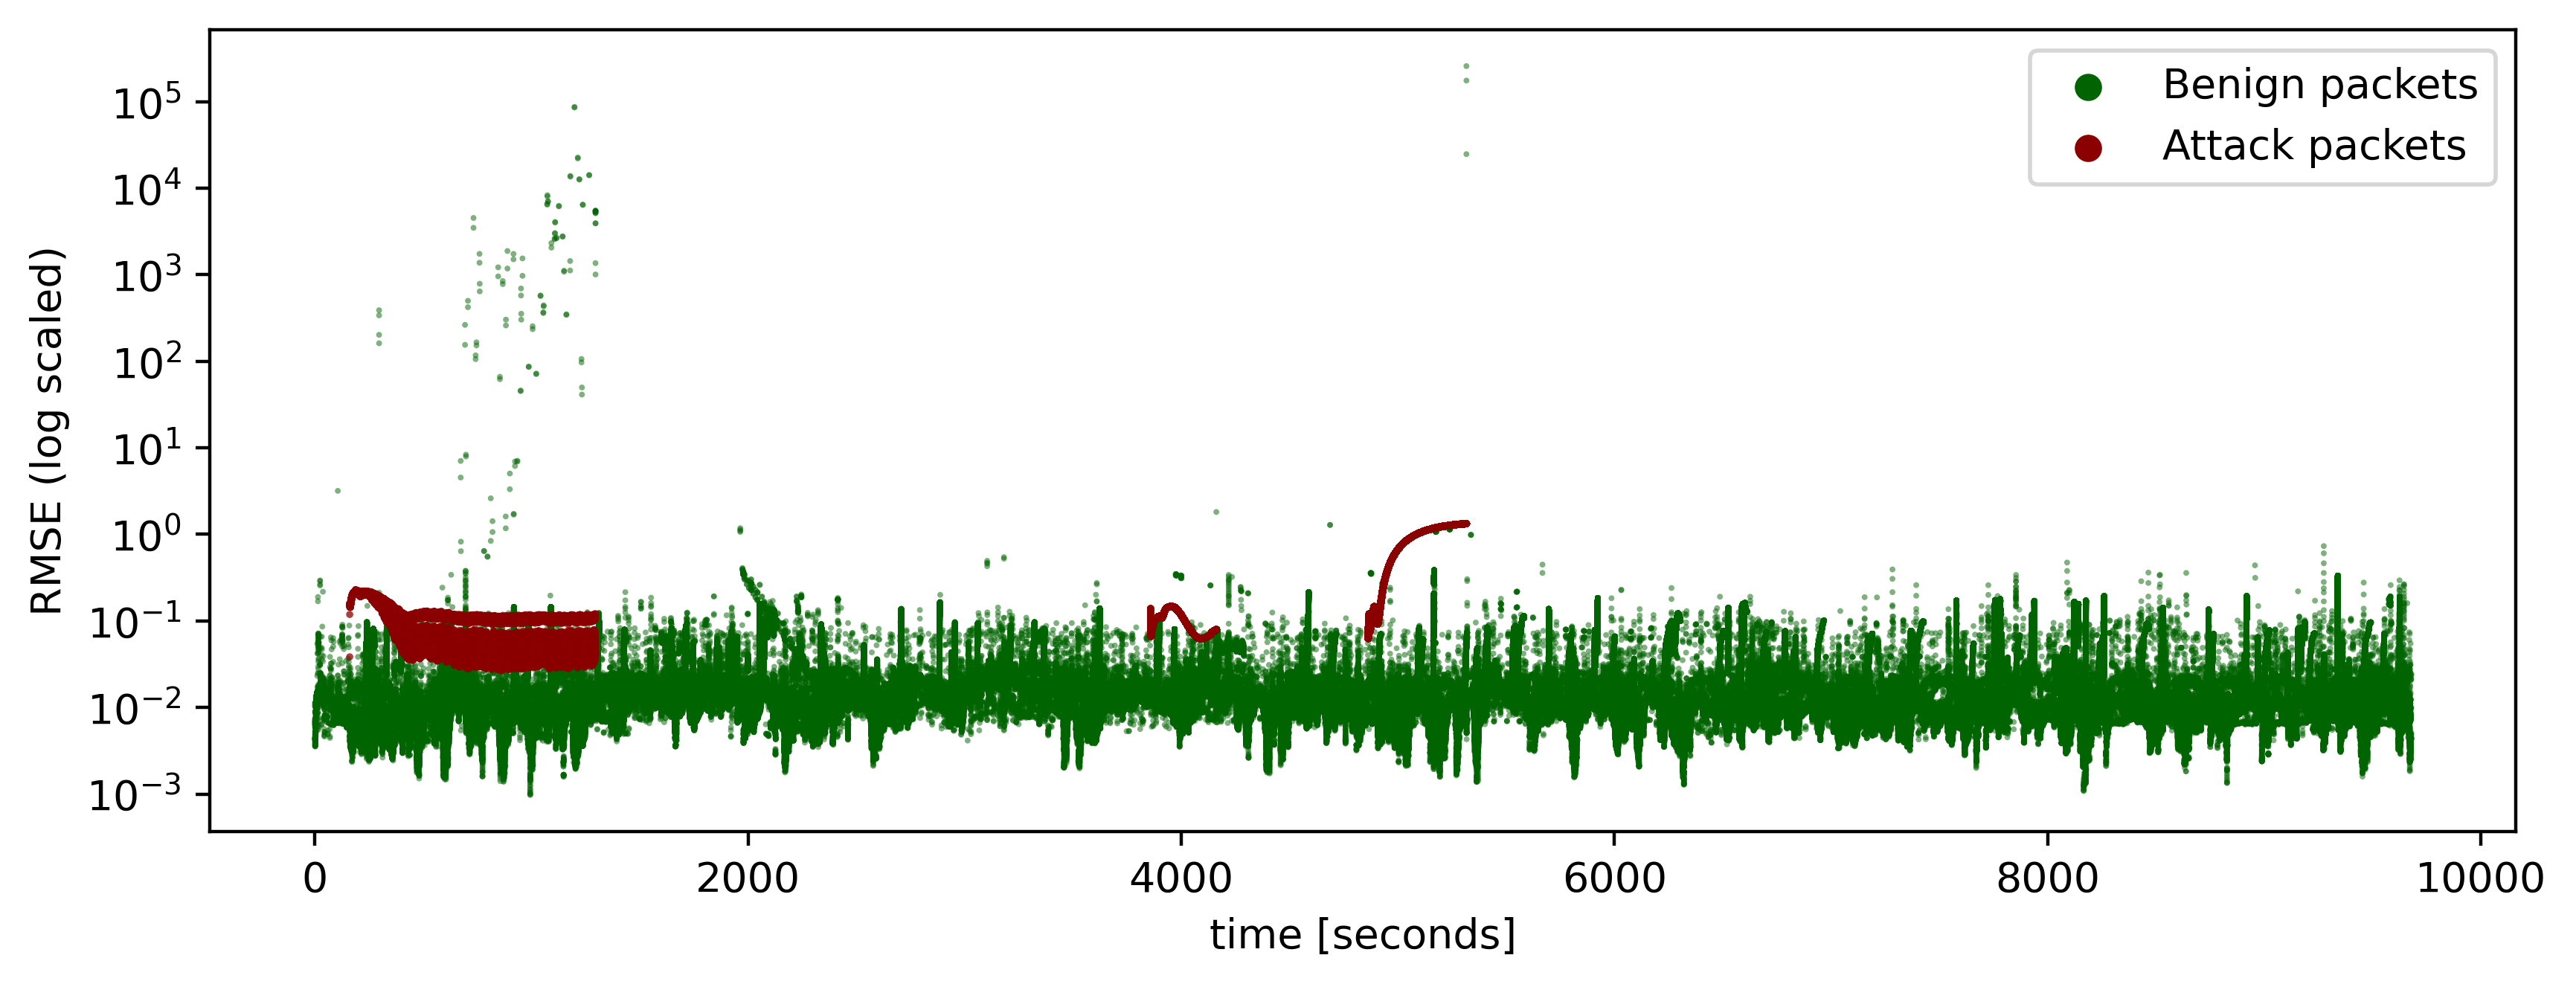

In [10]:
# Per-packet RMSEs by time
plot_pkt_rmses(pkt_rmse_kitsune, pkt_labels, pkt_timestamps)

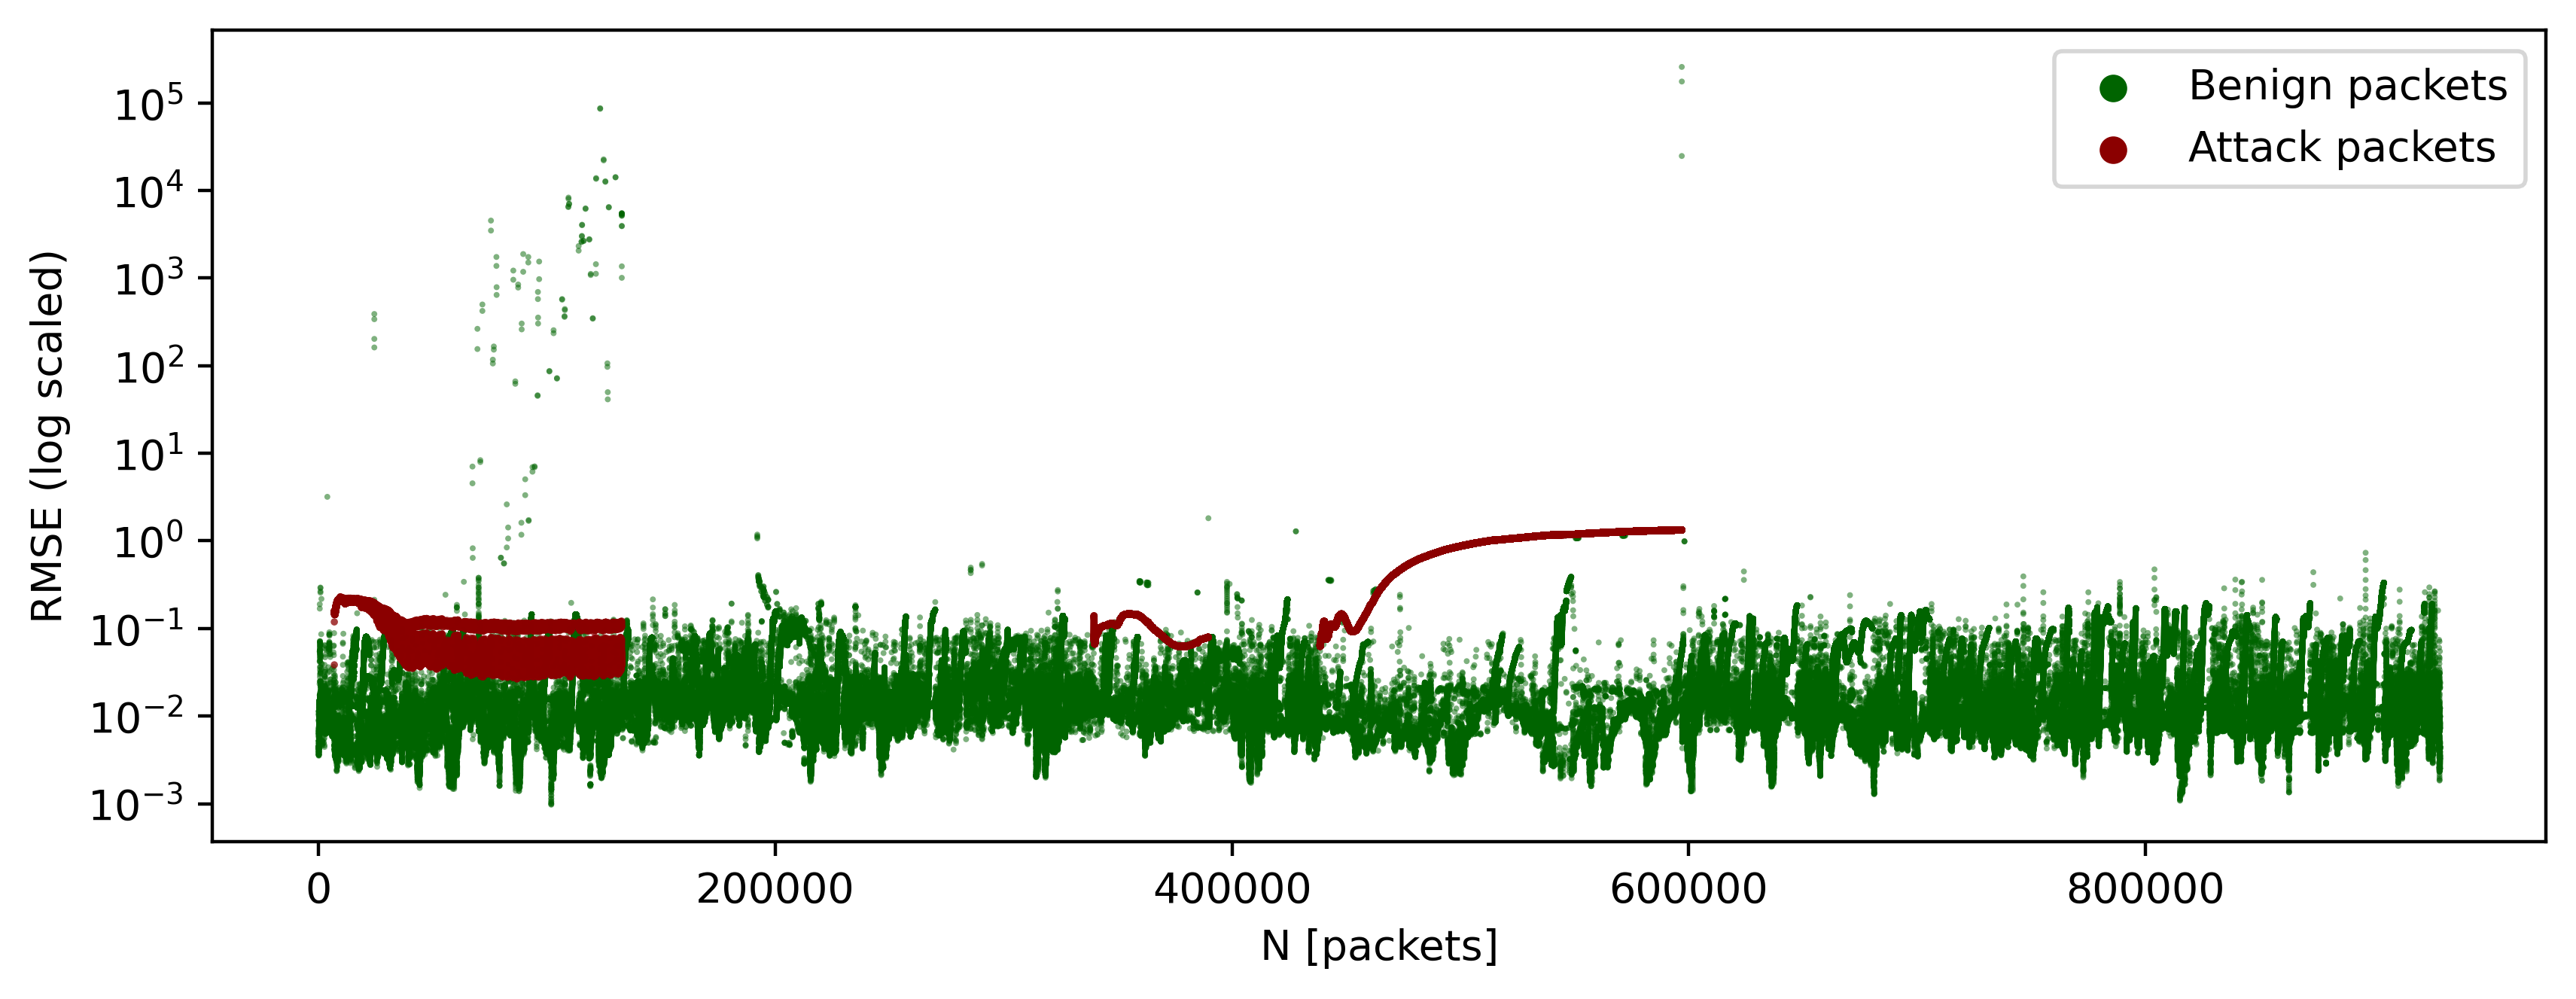

In [11]:
# Per-packet RMSEs by packet count
plot_pkt_rmses(pkt_rmse_kitsune, pkt_labels)

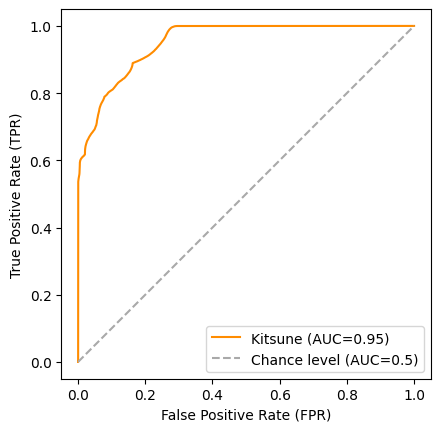

In [12]:
# ROC curve of Kitsune predictions
plot_roc([(pkt_rmse_kitsune, pkt_labels, "Kitsune", 'darkorange')])

## Windower Evaluation

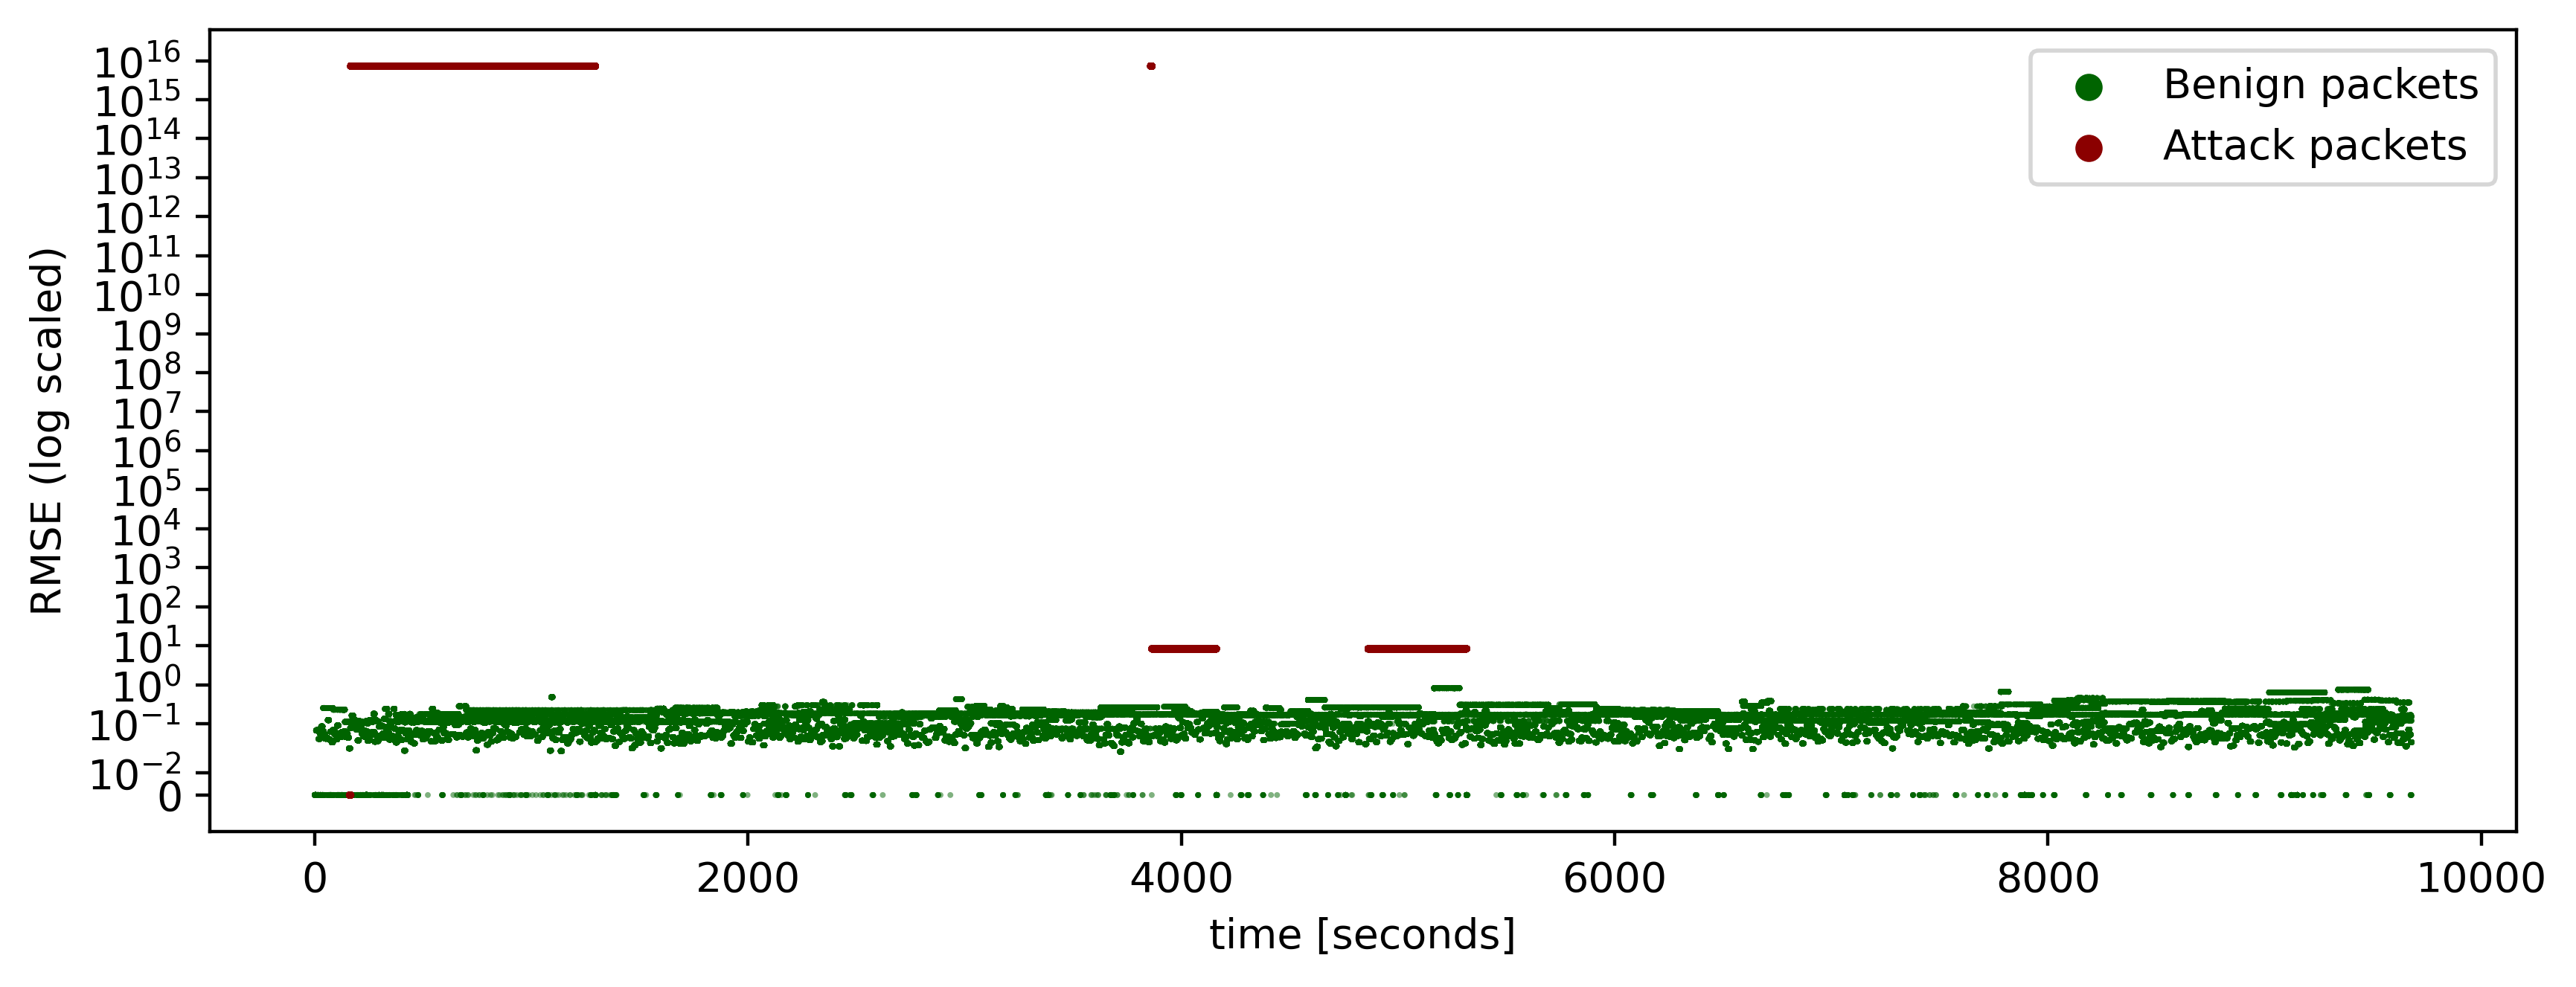

In [13]:
# Per-packet RMSEs by time
plot_pkt_rmses(pkt_rmse_windower, pkt_labels, pkt_timestamps)

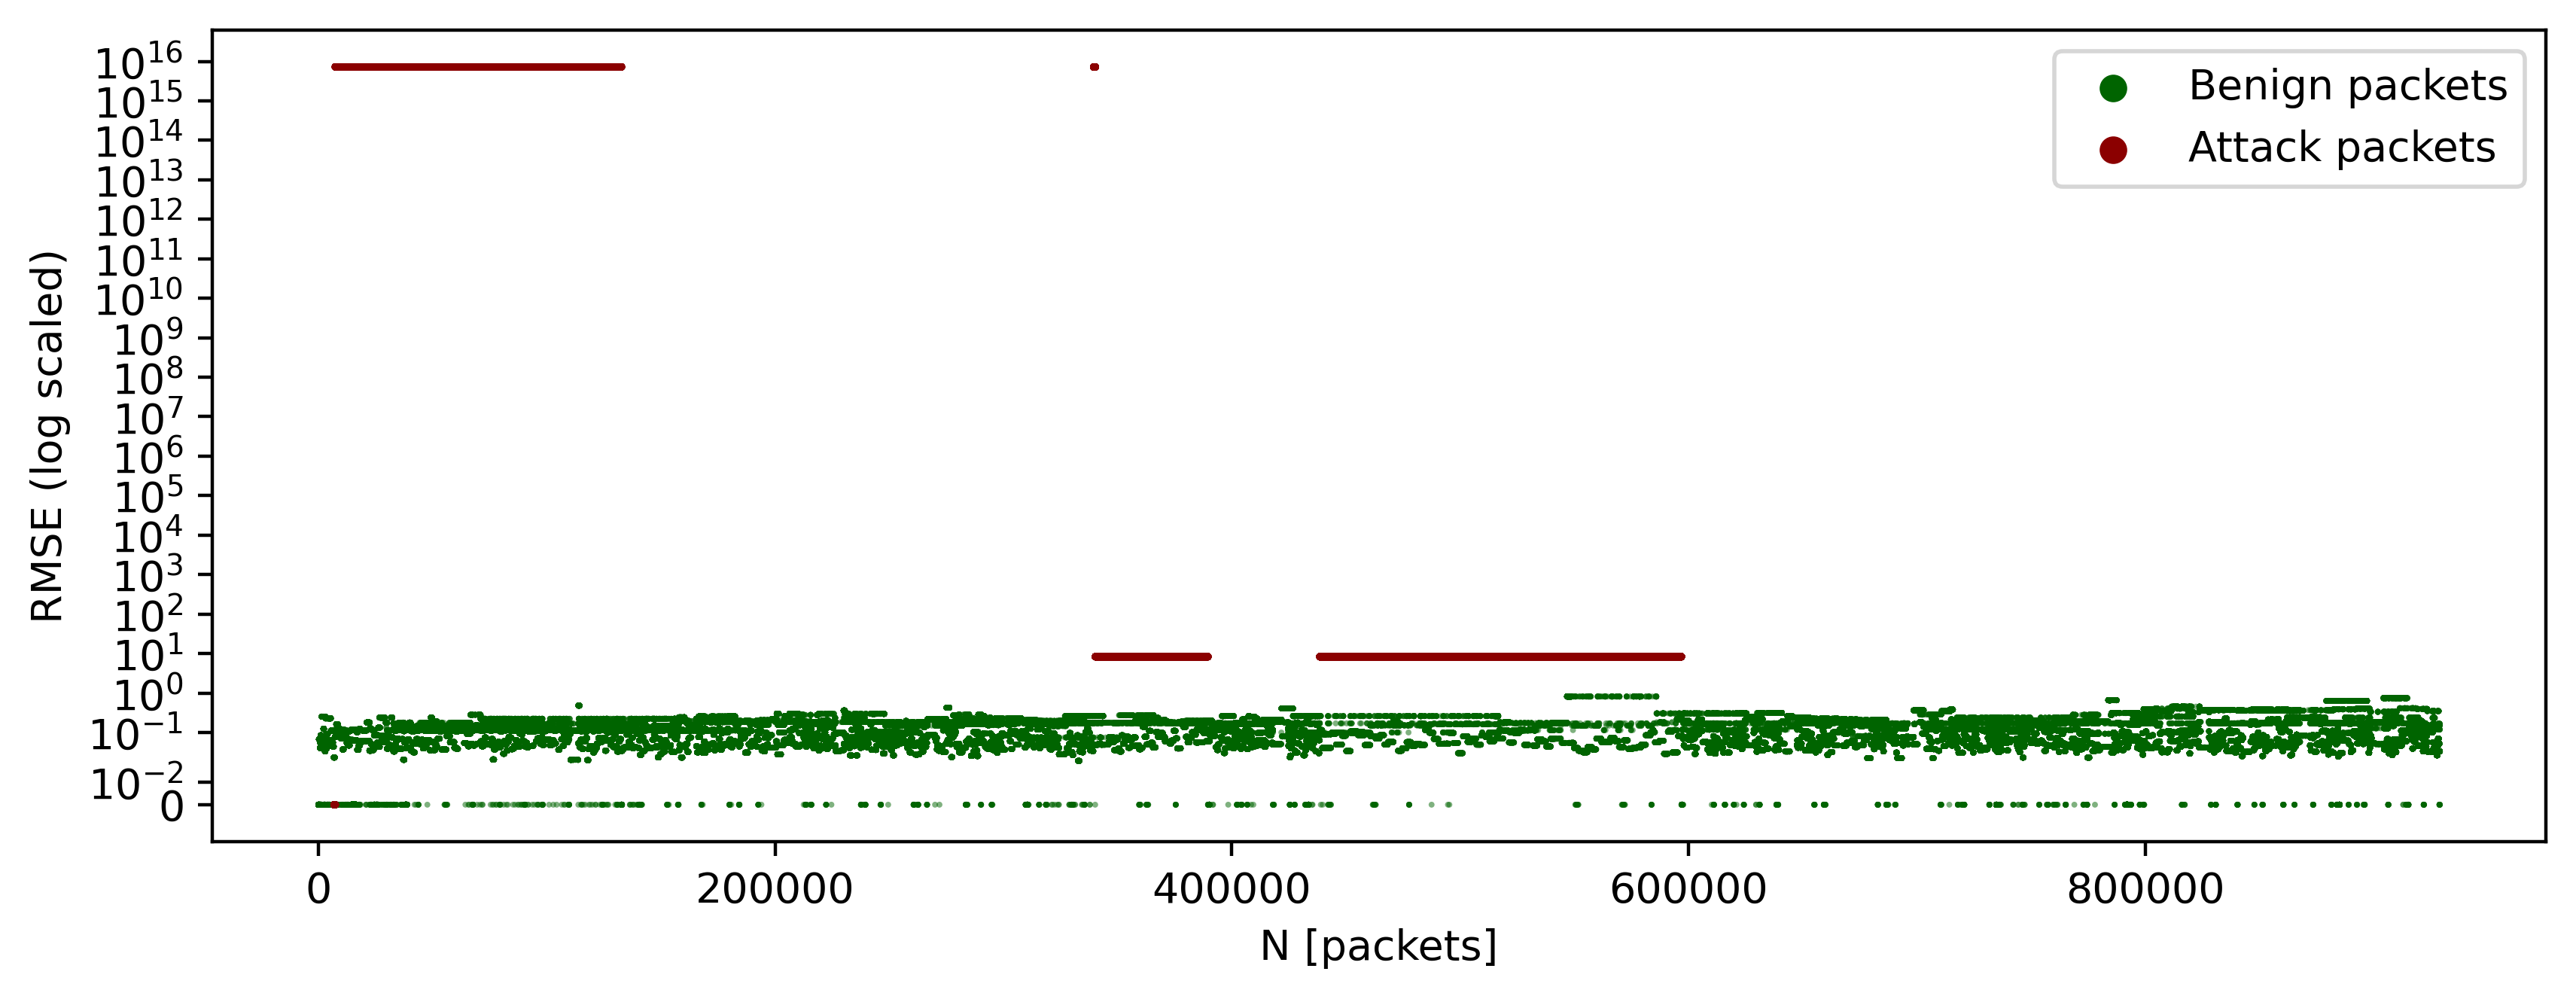

In [14]:
# Per-packet RMSEs by packet count
plot_pkt_rmses(pkt_rmse_windower, pkt_labels)

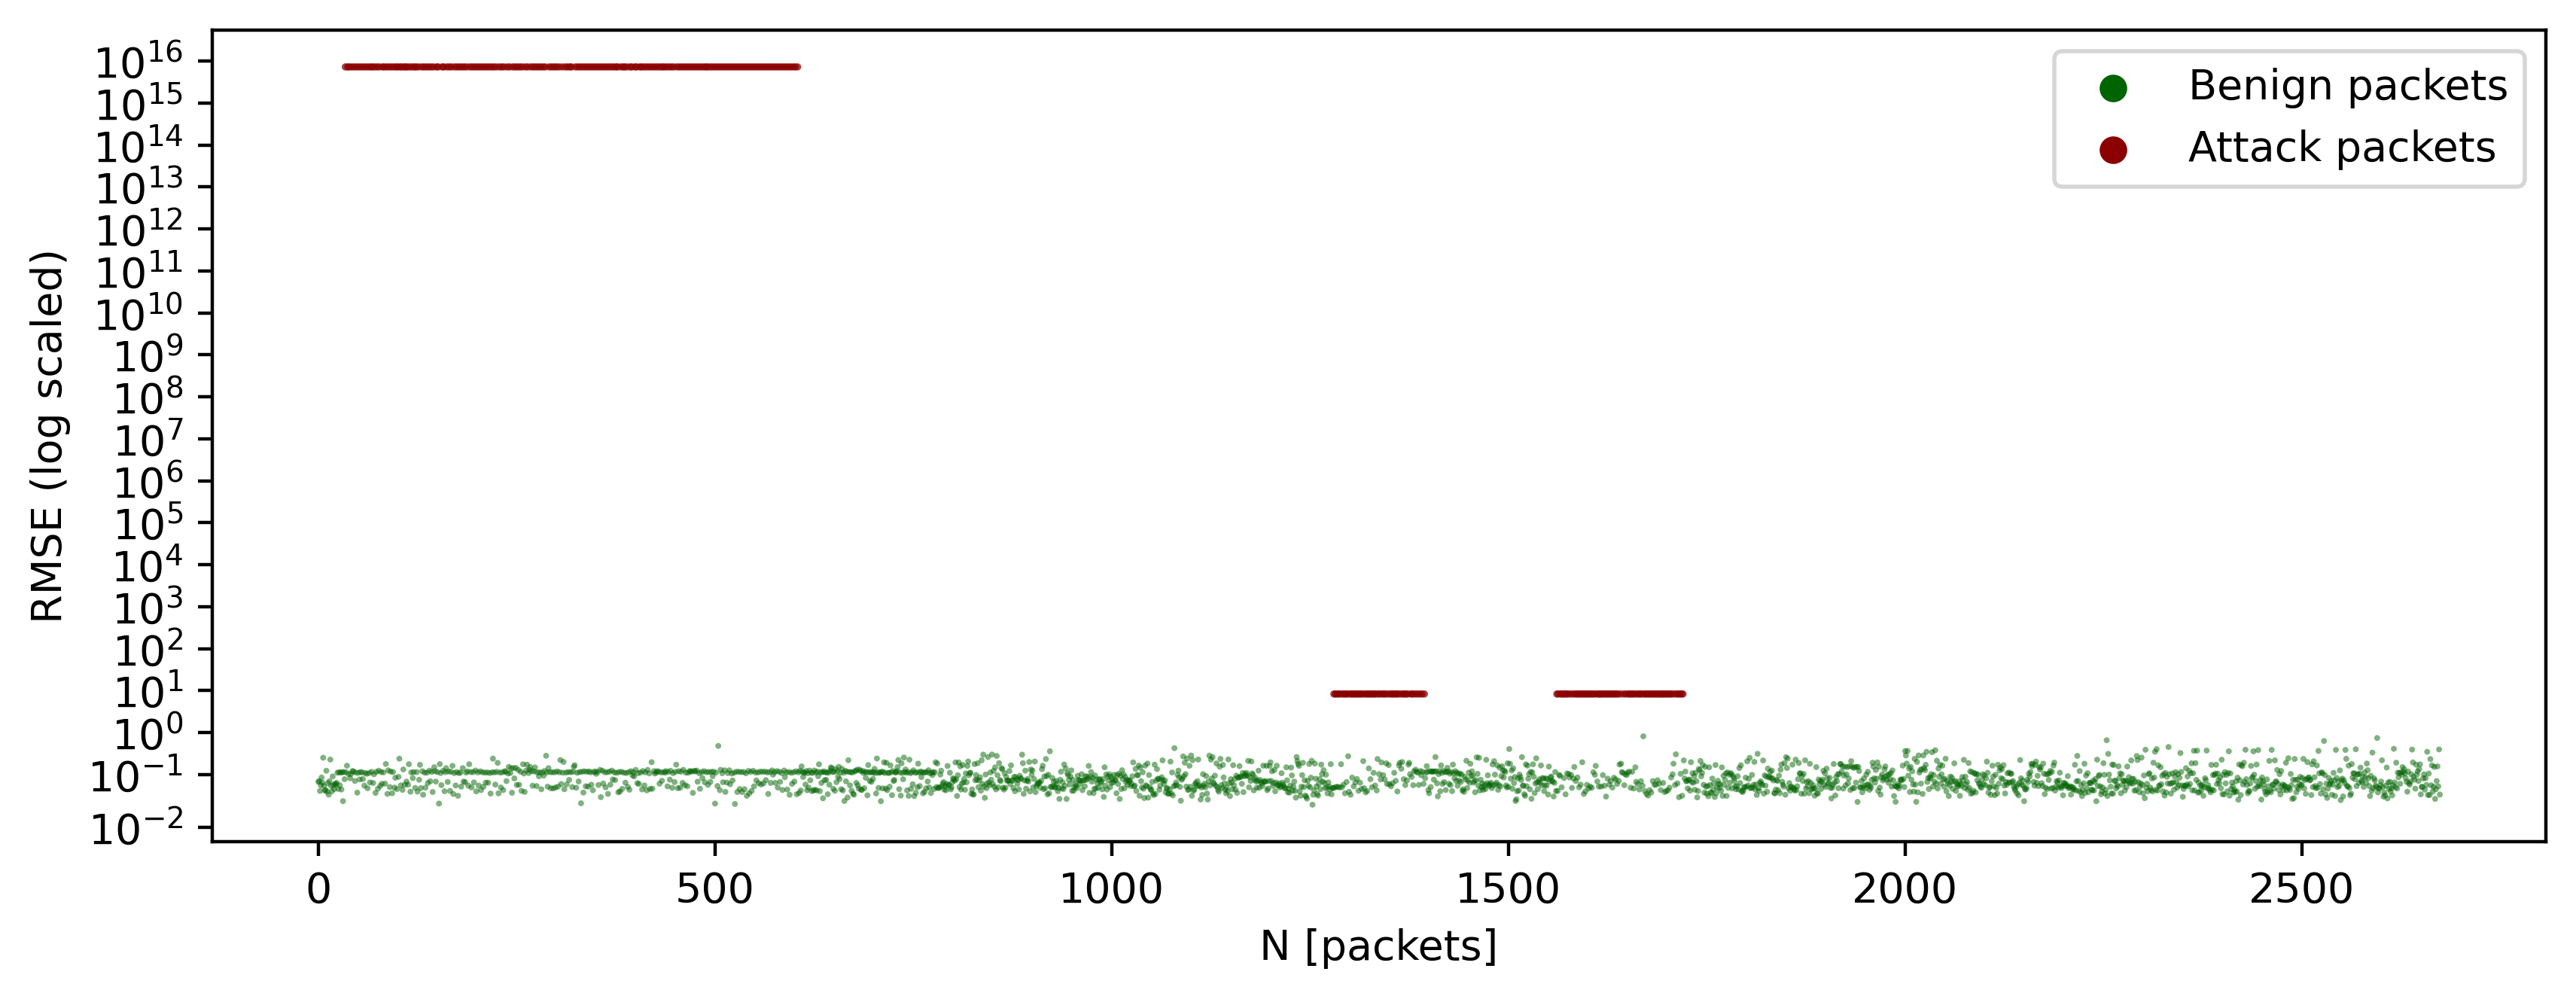

In [15]:
# Plot per-window RMSE plot - the X axis are actually classified Windower's windows, not packets
plot_pkt_rmses(winds_rmse_windower, winds_labels_windower)

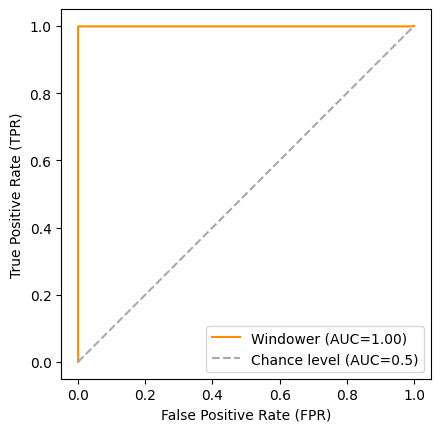

In [16]:
# ROC curve of Windower predictions
plot_roc([(pkt_rmse_windower, pkt_labels, 'Windower', 'darkorange')])

## Performance Comparison

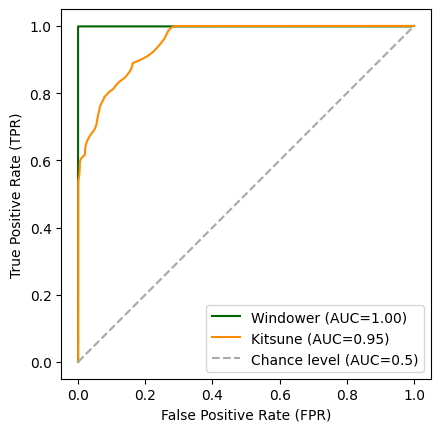

In [17]:
# Finally, compare the performance of Windower and Kitsune using a ROC curve
plot_roc([(pkt_rmse_windower, pkt_labels, 'Windower', 'darkgreen'), (pkt_rmse_kitsune, pkt_labels, "Kitsune", 'darkorange')])

### Pipeline Scripts

In order to evaluate and compare performance in a high number of parallel scenarios, we also implemented and internally used Python scripts for performance analysis instead of the Jupyter notebooks presented here. For this reason, most of the Jupyter cells were simply calls to existing scripts and bash commands. Nevertheless, we also implemented scripts to plot the results, listed under `src/utils/plot` folder.